# 캐글 데이터분석_집 가격 예측하기

## Step 1. 데이터 준비하기

In [1]:
# 필요한 모듈 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 데이터 전처리하기

In [4]:
# date 전처리(정수형 데이터로 처리)
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head

<bound method NDFrame.head of           id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0          0  201410   221900.0         3       1.00         1180      5650   
1          1  201502   180000.0         2       1.00          770     10000   
2          2  201502   510000.0         3       2.00         1680      8080   
3          3  201406   257500.0         3       2.25         1715      6819   
4          4  201501   291850.0         3       1.50         1060      9711   
...      ...     ...        ...       ...        ...          ...       ...   
15030  15030  201410   610685.0         4       2.50         2520      6023   
15031  15031  201503  1007500.0         4       3.50         3510      7200   
15032  15032  201405   360000.0         3       2.50         1530      1131   
15033  15033  201502   400000.0         4       2.50         2310      5813   
15034  15034  201410   325000.0         2       0.75         1020      1076   

       floors  waterf

In [5]:
# y 변수에 price를 넣은 뒤, train에서 price삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# id 컬럼 제거
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
# 테스트데이터 date 전처리 및 id 컬럼 제거
# price는 우리가 예측해야 하므로 테스트데이터에는 price 컬럼이 없음
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


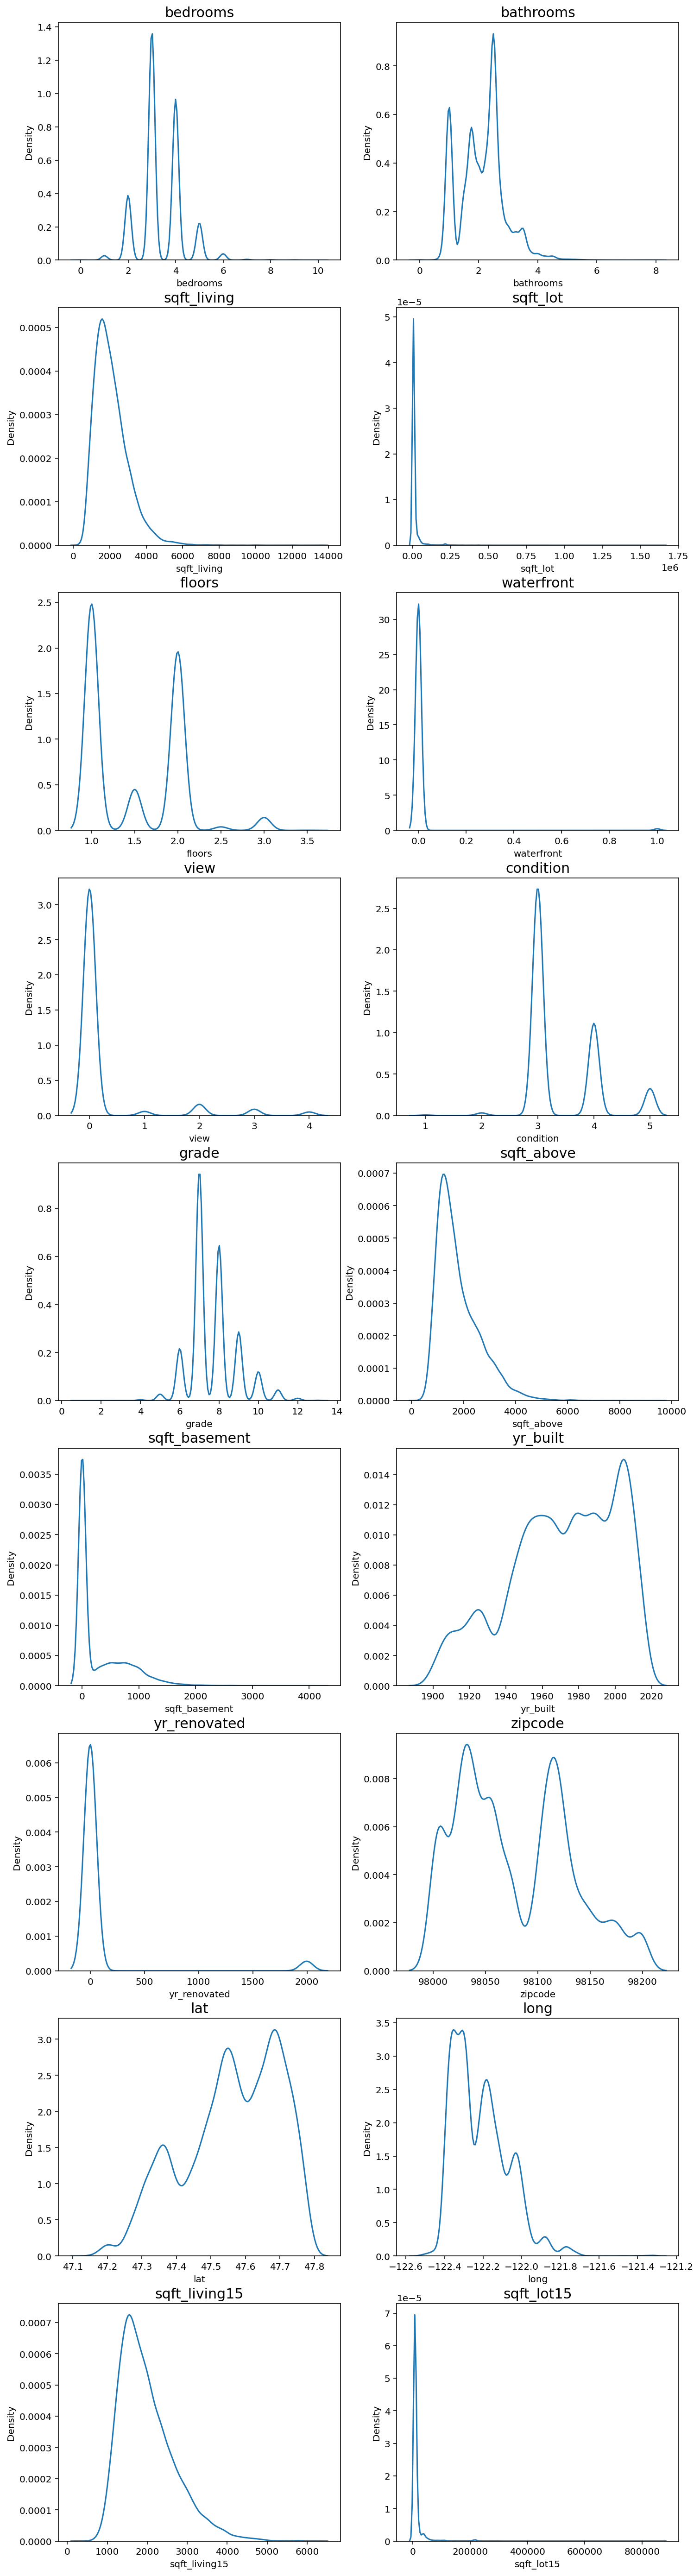

In [8]:
# 각 변수들의 분포 확인하기(id 변수 제외)
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) # 9행 2열의 subplot 그래프 그리기

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col]) # sns.kdepplot() : 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

In [9]:
# 치우친 컬럼들 skew_columns 안에 담기
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
# numpy.loglp() : 입력 배열의 각 요소에 대해 자연로그 log(1+x)을 반환해주는 함수

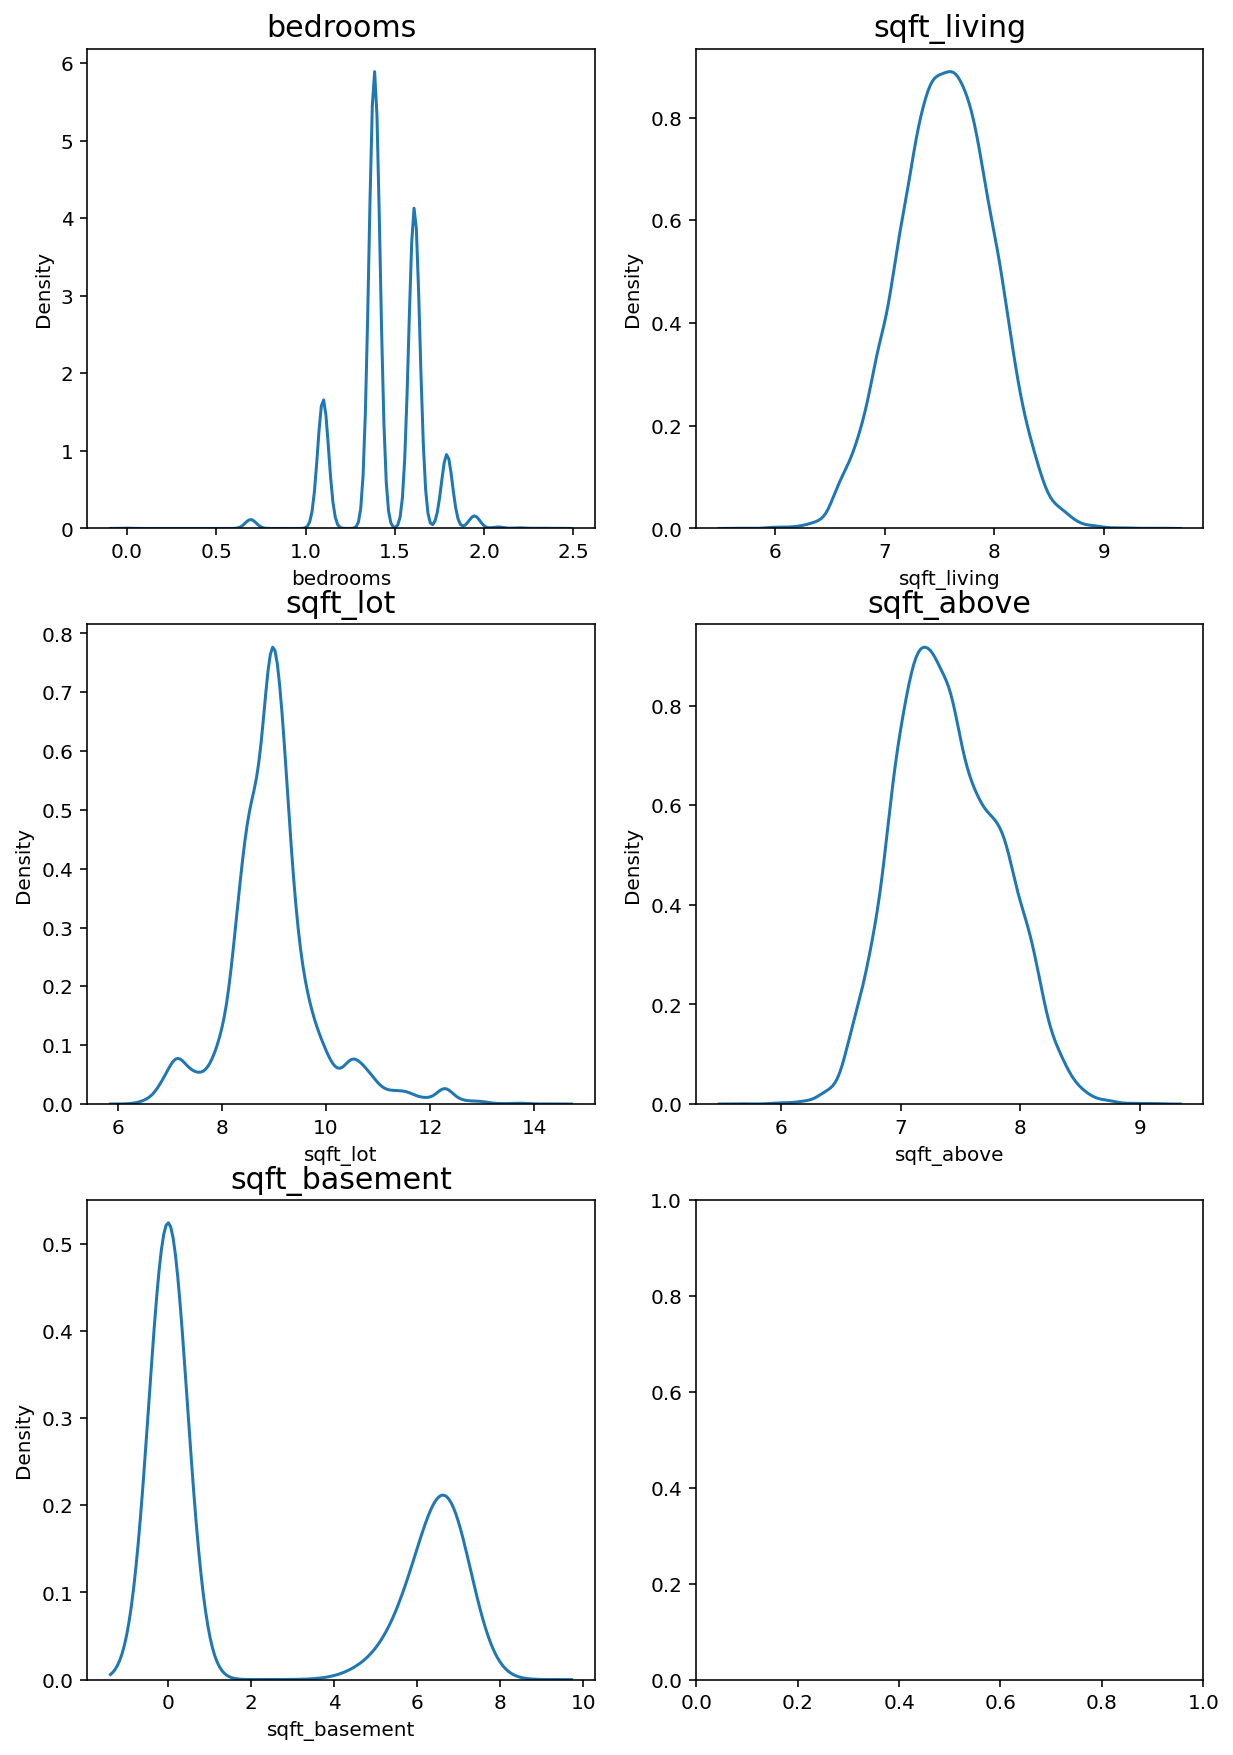

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15)) # 3행 2열

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

로그 변환을 통해 각 변수들의 분포를 정규분포에 가깝게 만들어주었다.  
그 과정에서 궁금한 점이 생겼는데, 5번째일 때 break 하라고 되어있는데 그럼 5번째 그래프는 그려지면 안되는 거 아닐까 하는 것이다. 그리고 if count == 5: break 여기서 5대신 7을 넣었는데, 그래프는 그려지지만 IndexError: list index out of range가 발생했다. 총 6개의 그래프를 설정해줬는데 7번째를 불러오니까 나온 에러인 거 같다는 생각이 들었다. 하지만 위에서 치우친 그래프 그릴 때에는 9행 2열로 만들 때 if count == 19: break 라고 했음에도 에러가 뜨지 않았다는 것이다. 이 부분은 정보를 더 찾아봐야겠다.

In [11]:
# 타겟데이터 y 확인
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

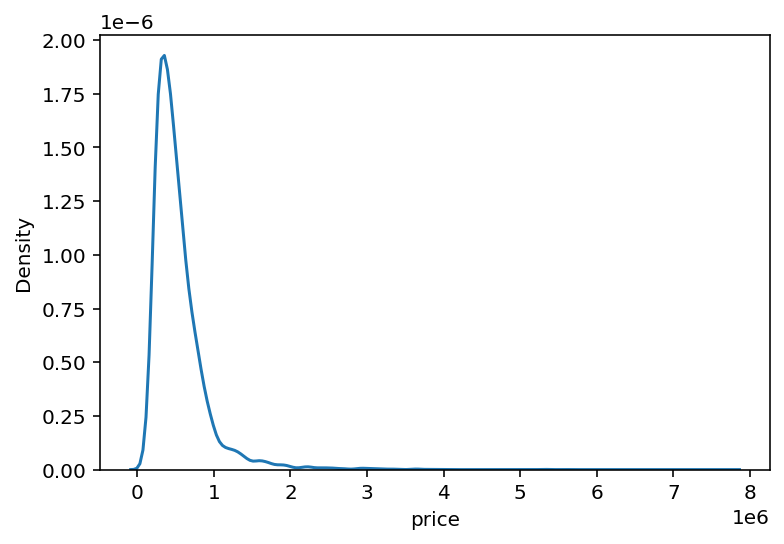

In [12]:
# y의 분포 확인
sns.kdeplot(y)
plt.show()

((array([-3.91024552, -3.69050911, -3.57011438, ...,  3.57011438,
          3.69050911,  3.91024552]),
  array([  78000.,   80000.,   81000., ..., 6885000., 7062500., 7700000.])),
 (311259.39937053947, 540682.653142667, 0.8376098994462499))

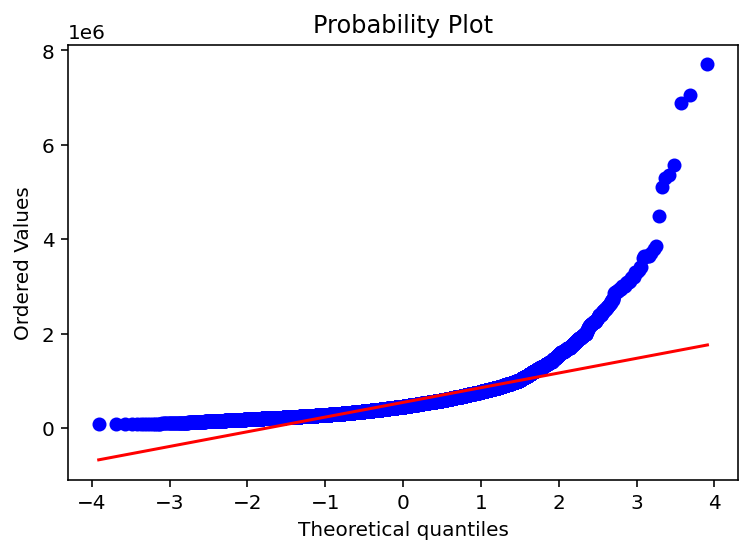

In [13]:
# Q-Q plot을 사용해 정규성 확인해보기
import scipy.stats as stats

stats.probplot(y, plot=plt)

피처 엔지니어링에 대해 찾아보다가 로그 변환이 데이터를 정규분포에 맞게 변형시켜주는 피처 엔지니어링 중 하나라는 것을 알게 되었다. 그러면서 Probplot으로 표현해서 파란점이 빨간선에 가까울수록 정규성을 만족한다는 점을 알게 되어서 로그 변환 전후로 정규성이 어느정도 차이나는지 궁금했다.

In [14]:
# 로그 변환 후 분포 다시 확인
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

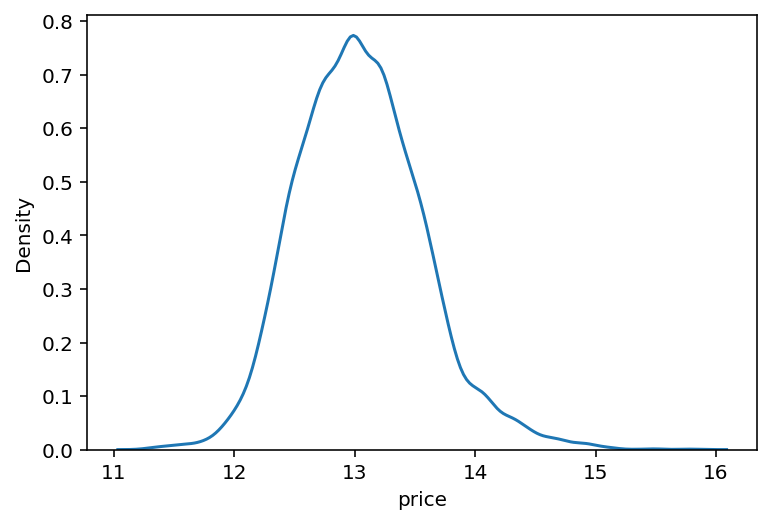

In [15]:
sns.kdeplot(y)
plt.show()

((array([-3.91024552, -3.69050911, -3.57011438, ...,  3.57011438,
          3.69050911,  3.91024552]),
  array([11.26447693, 11.28979441, 11.30221678, ..., 15.74485584,
         15.7703098 , 15.85673102])),
 (0.5246386762816583, 13.04812230186611, 0.9944175231748045))

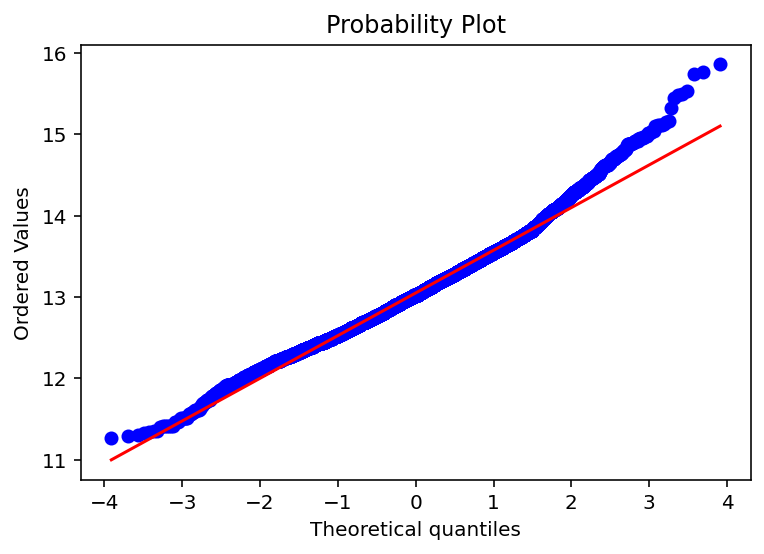

In [16]:
# Q-Q plot을 사용해 정규성 확인해보기
import scipy.stats as stats

stats.probplot(y, plot=plt)

kdeplot을 통해서도 로그 변환 후 정규화되었다는 것을 확인할 수 있었지만 probplot을 통해서 로그 변환 후 정규화가 잘 되었다는 것을 확인할 수 있었다.

In [17]:
# 전체데이터 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## Step 2. RMSE 계산하기

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [19]:
# rmse 함수 만들기
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
# expm1() : np.log1p()로 변환된 값을 원래대로 되돌리는 함수
#np.sqrt(mean_squared_error()) : rmse

In [20]:
# 튜닝할 수 있는 모델 import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [21]:
random_state=2022

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

random_state : 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값  
None이 초기값으로 모델 내부에서 임의로 선택된다. 하지만 임의로 선택될 경우 파라미터 초기화나 데이터셋 구성 양상이 달라져 모델과 데이터셋이 동일해도 머신러닝 학습결과는 학습할 때마다 달라진다.   
이를 방지하기 위해 random_state값을 2022로 고정시켰다.

In [22]:
# 모델의 이름 얻기
gboost.__class__.__name__

'GradientBoostingRegressor'

In [23]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리(random_state 고정) 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 130363.55955815461,
 'XGBRegressor': 127900.25400477885,
 'LGBMRegressor': 120306.55308655716,
 'RandomForestRegressor': 134957.58866507854}

In [24]:
# get_scores 함수 만들기
def get_scores(models, train, y):
    df = {}

    # 모델 이름 획득하기
    for model in models:
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리(random_state 고정)
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train) # 학습
        y_pred = model.predict(X_test) # 예측

        df[model_name] = rmse(y_test, y_pred) # 예측 결과의 rmse값 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        # 인덱스를 RMSE로 내림차순으로 데이터 프레임에 저장

    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,134957.588665
GradientBoostingRegressor,130363.559558
XGBRegressor,127900.254005
LGBMRegressor,120306.553087


중간에 함수 만드는 확인 과정을 거치지 않고 바로 get_scores()함수를 만들었는데 실행이 안되었다. error가 뜨지 않아서 어디서 잘못된지 모르고 찾아보다가 함수 만드는 과정을 확인하면서 실행이 안됐던 이유를 알게 되었다. error의 o를 e라고 잘못 적었고, squared의 e를 빼고 잘못 적었다. 컴퓨터는 알파벳 하나만 잘못 적어도 실행되지 않는 민감한 아이라는 것을 다시 한 번 느꼈고 더 꼼꼼해져야겠다는 생각이 들었다.  
로그 변환만 한 상태라 RMSE의 값이 아직은 많이 높은 상태인 거 같다. 하이퍼 파라미터를 통해 RMSE의 값을 낮춰봐야겠다.

## Step 3. 하이퍼 파라미터 튜닝하기(그리드 탐색)

### lightgbm을 사용하여 튜닝하기

In [25]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


In [26]:
from sklearn.model_selection import GridSearchCV

In [57]:
LGBM = LGBMRegressor(random_state=random_state)

In [58]:
lgbm_param_grid = {
    'num_leaves' : [1, 5, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200, 500], 
    'max_depth': [15, 20, 25],
    'min_split_gain': [0.3, 0.4]
}

In [59]:
lgbm_model = GridSearchCV(LGBM, param_grid=lgbm_param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

lgbm_model.fit(train, y)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2022), n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [15, 20, 25],
                         'min_split_gain': [0.3, 0.4],
                         'n_estimators': [50, 100, 200, 500],
                         'num_leaves': [1, 5, 10]},
             scoring='neg_mean_squared_error', verbose=1)

In [60]:
lgbm_model.cv_results_

{'mean_fit_time': array([0.05103831, 0.59797492, 0.71756988, 0.03092971, 0.81041732,
        1.02110348, 0.02717175, 1.2464973 , 1.27641006, 0.03264384,
        2.04989371, 2.08148017, 0.03779087, 0.57093453, 0.70367432,
        0.03193436, 0.80862365, 0.92467089, 0.04441853, 1.20583048,
        1.29219227, 0.02018051, 1.99705524, 2.15548363, 0.01291342,
        0.46611309, 0.68021989, 0.02691464, 0.8224287 , 0.96094971,
        0.02989793, 1.23601942, 1.28580842, 0.02402244, 2.09146724,
        2.14222779, 0.0297822 , 0.55094004, 0.68137131, 0.02915292,
        0.78558512, 0.97344422, 0.02733936, 1.20237222, 1.24891071,
        0.02379165, 1.99734693, 2.08807416, 0.0187191 , 0.55625806,
        0.68702183, 0.02962375, 0.8402164 , 1.01906719, 0.03143115,
        1.22425594, 1.29768934, 0.03024497, 2.12941313, 2.12785926,
        0.02950959, 0.4907299 , 0.6764164 , 0.02542896, 0.87461457,
        0.91520848, 0.03503947, 1.14378061, 1.27793732, 0.03954391,
        2.03215833, 2.11323442,

In [61]:
params = lgbm_model.cv_results_['params']
params

[{'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 50,
  'num_leaves': 1},
 {'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 50,
  'num_leaves': 5},
 {'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 50,
  'num_leaves': 10},
 {'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 100,
  'num_leaves': 1},
 {'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 100,
  'num_leaves': 5},
 {'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 100,
  'num_leaves': 10},
 {'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 200,
  'num_leaves': 1},
 {'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 200,
  'num_leaves': 5},
 {'learning_rate': 0.1,
  'max_depth': 15,
  'min_split_gain': 0.3,
  'n_estimators': 200,
  'num_leaves': 10},
 

In [62]:
score = lgbm_model.cv_results_['mean_test_score']
score

array([        nan, -0.04327449, -0.03471642,         nan, -0.03495928,
       -0.03083157,         nan, -0.0321518 , -0.03083157,         nan,
       -0.0321518 , -0.03083157,         nan, -0.04327449, -0.03471512,
               nan, -0.03496188, -0.03146511,         nan, -0.03312006,
       -0.03146511,         nan, -0.03312006, -0.03146511,         nan,
       -0.04327449, -0.03471642,         nan, -0.03495928, -0.03083157,
               nan, -0.0321518 , -0.03083157,         nan, -0.0321518 ,
       -0.03083157,         nan, -0.04327449, -0.03471512,         nan,
       -0.03496188, -0.03146511,         nan, -0.03312006, -0.03146511,
               nan, -0.03312006, -0.03146511,         nan, -0.04327449,
       -0.03471642,         nan, -0.03495928, -0.03083157,         nan,
       -0.0321518 , -0.03083157,         nan, -0.0321518 , -0.03083157,
               nan, -0.04327449, -0.03471512,         nan, -0.03496188,
       -0.03146511,         nan, -0.03312006, -0.03146511,      

In [63]:
results = pd.DataFrame(params)
results['score'] = score

results

,learning_rate,max_depth,min_split_gain,n_estimators,num_leaves,score
0,0.100,15,0.3,50,1,NaN
1,0.100,15,0.3,50,5,-0.043274
2,0.100,15,0.3,50,10,-0.034716
3,0.100,15,0.3,100,1,NaN
4,0.100,15,0.3,100,5,-0.034959
...,...,...,...,...,...,...
211,0.001,25,0.4,200,5,-0.222396
212,0.001,25,0.4,200,10,-0.214460
213,0.001,25,0.4,500,1,NaN
214,0.001,25,0.4,500,5,-0.165546


In [64]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,learning_rate,max_depth,min_split_gain,n_estimators,num_leaves,score,RMSE
0,0.100,15,0.3,50,1,NaN,NaN
1,0.100,15,0.3,50,5,-0.043274,0.208025
2,0.100,15,0.3,50,10,-0.034716,0.186323
3,0.100,15,0.3,100,1,NaN,NaN
4,0.100,15,0.3,100,5,-0.034959,0.186974
...,...,...,...,...,...,...,...
211,0.001,25,0.4,200,5,-0.222396,0.471589
212,0.001,25,0.4,200,10,-0.214460,0.463098
213,0.001,25,0.4,500,1,NaN,NaN
214,0.001,25,0.4,500,5,-0.165546,0.406874


In [65]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,min_split_gain,n_estimators,num_leaves,score,RMSLE
0,0.100,15,0.3,50,1,NaN,NaN
1,0.100,15,0.3,50,5,-0.043274,0.208025
2,0.100,15,0.3,50,10,-0.034716,0.186323
3,0.100,15,0.3,100,1,NaN,NaN
4,0.100,15,0.3,100,5,-0.034959,0.186974
...,...,...,...,...,...,...,...
211,0.001,25,0.4,200,5,-0.222396,0.471589
212,0.001,25,0.4,200,10,-0.214460,0.463098
213,0.001,25,0.4,500,1,NaN,NaN
214,0.001,25,0.4,500,5,-0.165546,0.406874


In [66]:
results = results.sort_values('RMSLE')
results

,learning_rate,max_depth,min_split_gain,n_estimators,num_leaves,score,RMSLE
35,0.100,20,0.3,500,10,-0.030832,0.175589
5,0.100,15,0.3,100,10,-0.030832,0.175589
59,0.100,25,0.3,500,10,-0.030832,0.175589
8,0.100,15,0.3,200,10,-0.030832,0.175589
56,0.100,25,0.3,200,10,-0.030832,0.175589
...,...,...,...,...,...,...,...
201,0.001,25,0.3,500,1,NaN,NaN
204,0.001,25,0.4,50,1,NaN,NaN
207,0.001,25,0.4,100,1,NaN,NaN
210,0.001,25,0.4,200,1,NaN,NaN


In [46]:
# 위의 과정을 my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) 함수로 만들기
def my_GridSearch(lgbm_model, train, y, lgmb_param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    lgbm_model = GridSearchCV(lgbm_model, param_grid=lgmb_param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    lgbm_model.fit(train, y)

    # 결과값 저장
    params = lgbm_model.cv_results_['params']
    score = lgbm_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

learning_rate=0.100, max_dapth=20, min_split_gain=0.3, n_estimators=200, num_leaves=10일 때 가장 조합이 좋다.

In [90]:
lgbm_model = LGBMRegressor(learning_rate=0.100, max_dapth=20, min_split_gain=0.3, n_estimators=200, num_leaves=10, random_state=random_state)
lgbm_model.fit(train, y) # 학습
lgbm_prediction = lgbm_model.predict(test) # 예측
lgbm_prediction

[LightGBM] [Warning] Unknown parameter: max_dapth


array([13.64469716, 13.65706871, 14.44416936, ..., 14.05960535,
       13.89216293, 13.97378615])

In [91]:
lgbm_prediction = np.expm1(lgbm_prediction)
lgbm_predict

array([ 842977.85629994,  853471.5935626 , 1875093.0178934 , ...,
       1276464.32756802, 1079665.69279791, 1171487.99941869])

### GradientBoostingRegressor 모델 튜닝하기

In [71]:
GBC = GradientBoostingRegressor(random_state=random_state)

In [72]:
gb_param_grid = {
        'n_estimators' : [100,200,300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100,150],
        'max_features': [0.3, 0.1] 
}

In [73]:
gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs= 5, verbose = 1)
gsGBC.fit(train, y)
GBC_best = gsGBC.best_estimator_

# 최고 점수
gsGBC.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


-0.0270197555279419

In [74]:
# 최고 점수 RMSLE로 바꾸기
gsGBC_RMSLE = np.sqrt(-1 * gsGBC.best_score_)
gsGBC_RMSLE

0.164376870416558

In [75]:
# 최적의 값 찾기
GBC_best

GradientBoostingRegressor(max_depth=8, max_features=0.3, min_samples_leaf=100,
                          n_estimators=300, random_state=2022)

In [92]:
gsGBC = GradientBoostingRegressor(max_depth=8, max_features=0.3, min_samples_leaf=100, n_estimators=300, random_state=random_state)
gsGBC.fit(train, y) # 학습
GBC_prediction = gsGBC.predict(test) # 예측
GBC_prediction

array([13.67631435, 13.71930364, 14.47245544, ..., 13.87270691,
       13.76177065, 13.67654488])

In [93]:
GBC_prediction = np.expm1(GBC_prediction)
GBC_prediction

array([ 870056.30168435,  908275.05858155, 1928889.34095568, ...,
       1058862.69773278,  947677.55374568,  870256.89857046])

### RandomForestRegressor 모델 튜닝하기

In [78]:
RF = RandomForestRegressor()
rf_param_grid = {
        'n_estimators' : [1,10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
}

In [79]:
gsRF = GridSearchCV(RF, param_grid = rf_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs= 5, verbose = 1)
gsRF.fit(train, y)
RF_best = gsRF.best_estimator_

# 최고 점수
gsRF.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


-0.03471056599938167

In [81]:
# 최고 점수 RMSLE로 바꾸기
gsRF_RMSLE = np.sqrt(-1 * gsRF.best_score_)
gsRF_RMSLE

0.18630771857167291

In [83]:
# 최적의 값 찾기
RF_best

RandomForestRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=8)

In [94]:
gsRF = RandomForestRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=16, random_state=random_state)
gsRF.fit(train, y) # 학습
RF_prediction = gsRF.predict(test) # 예측
RF_prediction

array([13.19357828, 13.13745903, 14.30331968, ..., 13.7005165 ,
       13.44914078, 13.44306484])

In [95]:
RF_prediction = np.expm1(RF_prediction)
RF_prediction

array([ 536904.98216352,  507604.08343099, 1628742.93668121, ...,
        891370.44110132,  693245.40439878,  689046.05053631])

## Step 4. 제출하기

In [97]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [98]:
submission['price'] = lgbm_prediction
submission.head()

,id,price
0,15035,8.429779e+05
1,15036,8.534716e+05
2,15037,1.875093e+06
3,15038,5.630005e+05
4,15039,6.095684e+05


In [101]:
submission['price'] = GBC_prediction
submission.head()

,id,price
0,15035,8.700563e+05
1,15036,9.082751e+05
2,15037,1.928889e+06
3,15038,6.399981e+05
4,15039,6.266334e+05


In [100]:
submission['price'] = RF_prediction
submission.head()

,id,price
0,15035,5.369050e+05
1,15036,5.076041e+05
2,15037,1.628743e+06
3,15038,4.605148e+05
4,15039,4.897811e+05


In [102]:
submission_csv_path = '{}/submission_RMSLE_{}.csv'.format(data_dir, 'final')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_RMSLE_final.csv


In [103]:
# 위의 과정을 save_submission(model, train, y, test, model_name, rmsle) 함수로 만들기
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)

    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_RMSLE_final.csv'.format(data_dir)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

![kaggle4](https://user-images.githubusercontent.com/116326867/201672532-15130f02-44da-4e5d-a27e-911ff0cf8e26.png)

-----------

## 회고
1. 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission결과를 이미지로 제출하였다.   
전처리 후에 모델학습을 진행하고 가격을 예측한 과정들을 csv파일로 저장한 후에 캐글에 제출하였다. 그 결과 lms에 나온대로 따라했을 때에는 private score=116127.87308이 나왔고, lms를 따라서 튜닝했을 때에는 private score=115807.04439가 나왔다. 점수를 더 낮추고 싶어서 LGBMRegressor, XGBRegressor, RandomForestRegressor 등 다양한 모델에 대해 하이퍼 파라미터 튜닝도 시도해 보았고 다시 캐글에 제출한 결과 점수가 떨어지기는 커녕 엄청나게 올라가버렸다.  
2. 주피터 노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?  
전처리를 하는 데에는 큰 어려움은 없었던 거 같다. 하지만 최적화하는 과정이 잘 이해도 안가고 어떤 원리로 되는 건지도 모르겠고, 모델에 대해 하이퍼 파라미터 튜닝하라고 했는데 무엇을 어떻게 적용해야 하는지도 모르겠고, 마무리도 안된 기분이다. 머릿속에는 물음표만 가득했고 나에게 가장 어려웠던 프로젝트 중 하나였다.
3. 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000이하의 점수를 얻었는가?  
마지막으로 올린 파일은 40만점이 넘어가는 아주 충격적인 점수가 나왔다. 이 점수를 보고서 너무 충격적이고 너무 부끄러웠다. 하지만 11만점 이하의 점수를 받은 누군가의 코드를 많이 참고해서 기준 점수를 얻어내는 방법도 있었지만 아직 이 부분에 대한 이해가 충분하지 않았다고 생각했기 때문에 부끄러운 점수라도 일단 마무리를 짓고 더 추가해나가는 방향을 선택하기로 했다. 
4. 프로젝트를 진행하면서 느낀점 : 이번 프로젝트를 하면서 정말 많은 시간을 쏟았고 정말 많이 노력했는데 결과는 그렇지 못한 거 같아 많이 아쉽다. lms만 그대로 따라서 만드는 방법도 있었고 작은 점수를 가진 사람들의 코드를 참고하는 방법도 있었지만 어느정도 내 스스로 해놓은 상태에서 비교해보고 싶었고, 그 코드를 그대로 복사하는 건 보여주기 식 프로젝트밖에 안될 것이라는 생각이 가장 크게 들었던 거 같다. 그리고 비교하며 참고하고 싶어도 아예 방향이 잘못된 거 같아 어떻게 할 수가 없는 상황이었다. 이번 프로젝트를 진행하면서 가장 많이 느낀 점은 내가 정말 많이 부족하다는 것이다. 알고는 있었지만 그 이상으로 많이 부족한 거 같다. 지난 프로젝트 이번에 받았던 40만점이 추억으로 남을 수 있도록 더 보완하고 공부해야겠다. 그리고 다른 사람들이 짠 코드들을 많이 보면서 어떤 식으로 풀어나가는지 배워야겠다.

## Reference
[Feature Engineering](https://magoker.tistory.com/118)  
[Probplot](https://mizykk.tistory.com/44)  
[lightgbm 인자1](https://injo.tistory.com/48)  
[lightgbm 인자2](https://potato-potahto.tistory.com/entry/Light-GBM-%EC%84%A4%EB%AA%85%ED%8A%B9%EC%A7%95%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0%EC%84%A4%EC%B9%98-%EC%82%AC%EC%9A%A9%EB%B0%A9%EB%B2%95)  
[LGBMRegressor, XGBRegressor, RandomForestRegressor](https://minding-deep-learning.tistory.com/m/17)